### Week 7: KNN, Naive Bayes Classifier, and ROC/AUC analysis

- #### Aims:
    - ##### Implement a KNN classifier
    - ##### Implement a Naive Bayes classifier
    - ##### Compare the two classifiers with ROC and AUC

In [1]:
import numpy as np
import pylab as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score 
from collections import Counter
from random import seed
from random import randrange
from sklearn.decomposition import PCA
from sklearn import feature_selection

%matplotlib inline

#### Task 1:  Implement a KNN classifier


##### Task 1.1: Load classification data
Download `trainx.csv` and `testx.csv` from Moodle. In trainx.csv, each row corresponds to an instance. The first two columns are the values for two features and the third is the class label. The same format is used in `testx.csv`. Load these datasets into python (numpy.loadtxt) and create an X matrix consisting of the first two columns and a t vector as the last one. Do the same for the test data so you have four objects: $\mathbf{X}$, $\mathbf{X}_{test}$, $\mathbf{t}$ and $\mathbf{t}_{test}$.

In [2]:
X_train = np.loadtxt('X_train.csv', delimiter=',', skiprows=1)
X_test = np.loadtxt('X_test.csv', delimiter=',', skiprows=1)
Y_train = np.loadtxt('y_train.csv', delimiter=',', skiprows=1)[:,1][:,None]

# Make an instance of the Model

from sklearn.preprocessing import StandardScaler
feature_scaler = StandardScaler()
X_train = feature_scaler.fit_transform(X_train)
X_test = feature_scaler.transform(X_test)




X_Y_train = np.column_stack((X_train,Y_train))
print(X_Y_train.shape)

(200, 113)


##### writting the function to split data for cross validation

In [3]:
# Split a dataset into k folds
def cross_validation_split(dataset, folds):
    dataset_split = list()
    dataset_copy = list(dataset)
    fold_size = int(len(dataset) / folds)
    for i in range(folds):
        fold = list()
        while len(fold) < fold_size:
            index = randrange(len(dataset_copy))
            fold.append(dataset_copy.pop(index))
        dataset_split.append(fold)
    return dataset_split
 
# test cross validation split
seed(1)
fold = 2
splited_data = np.array(cross_validation_split(X_Y_train,fold))
print(splited_data.shape)

(2, 100, 113)


##### Task 1.2: Write a KNN function for a single test example (a row)
Implement a KNN function that takes a single test example and a value of K and returns a classification. Your function should find the K closest (see below) training points to the test point and return the majority class
amongst these training points.

If your training data is in a numpy array with 100 rows and 2 columns, then the distance between a test point and the ith row is given by:

`sq_diff = (test_row - trainx[i,:])**2
dist = np.sqrt(sq_diff.sum())`

where test_row is a row of $\mathbf{X}_{test}$.
The first line creates a new vector which holds the squared difference of the two pairs of values. The second line takes the sum of these differences and then takes the square root. This is computing the Euclidean distance. Other distance metrics could also be used.

The `zip`, `sorted` and `numpy`'s `unique` can be helpful for finding the nearest neighbours.

Make sure your function returns both the predicted class and predicted score. For KNN, the score can be the percentage of votes for each class. 

In [4]:
def knn_classifier(trainX, traint, test_data, K):
    distances = np.sqrt( ((trainX - test_data)**2).sum(axis=1)) # computing distances from the testing data to all training data
    dc = zip(distances, traint) 
    dc = sorted(dc, key = lambda x: x[0]) # sort distance 
    selected_neighbor = np.asarray(dc[:K]) # select K number of neareast neighbours
    classes, counts = np.unique(selected_neighbor[:,1], return_counts=True)
    prediction = {}
    prediction["predicted_class"] = classes[counts.argmax()]
    
    if ( len(classes) == 1 and classes[counts.argmax()] == 2.0):
        prediction["predicted_score"] = np.hstack( (1.0- (1.0*counts/sum(counts)), 1.0*counts/sum(counts) ) )
    elif ( len(classes) == 1 and classes[counts.argmax()] == 1.0):
        prediction["predicted_score"] = np.hstack( ( 1.0*counts/sum(counts), 1.0- (1.0*counts/sum(counts)) ) )
    else:
        prediction["predicted_score"] = 1.0*counts/sum(counts)
    return(prediction)

##### Task 1.3: Test with cross_validation

In [5]:
results = []
for i in range(fold):
    fold_X_train = splited_data[i,:,:112]
    fold_Y_train = splited_data[i,:,112:]
    cross_fold_X_train, cross_fold_X_test, cross_fold_Y_train, cross_fold_Y_test = train_test_split(fold_X_train,fold_Y_train, test_size=0.5,random_state=1234)
    ctrain = Counter(cross_fold_Y_train.flatten())
    
    Kvals = np.arange(1,100,1)
    accuracy = []

    for k in Kvals:
        correct = 0
        for i,row in enumerate(cross_fold_X_test):
            c = knn_classifier(cross_fold_X_train,cross_fold_Y_train,row,K=k)["predicted_class"]
            if c == cross_fold_Y_test[i]:
                correct += 1
        accuracy.append(1.0*correct / (1.0*len(cross_fold_X_test)))
    results.append((max(accuracy),np.array(accuracy).argmax()))
print(results)
temp = 0
k = 0
for (i,j) in results:
    temp += i
    k += j
print("The average accuracy :",temp/len(results))
print("The average k :",k/len(results))








[(0.82, 7), (0.9, 0)]
The average accuracy : 0.86
The average k : 3.5


##### Task 1.4: make prediction for KNN

In [6]:
y_prediction = []
for i in range(len(X_test)):
    c = knn_classifier(X_train,Y_train,X_test[i,:],K=4)
    y_prediction.append(c["predicted_class"])
y_prediction = np.array(y_prediction)

In [7]:
test_header = "Id,EpiOrStroma"
n_points = X_test.shape[0]
y_pred_pp = np.ones((n_points, 2))
y_pred_pp[:, 0] = range(n_points)
y_pred_pp[:, 1] = y_prediction[:,0]
print(y_pred_pp)

np.savetxt('my_submission_k_nearest_neighbour_cl.csv', y_pred_pp, fmt='%d', delimiter=",",header=test_header, comments="")

[[  0.   2.]
 [  1.   2.]
 [  2.   2.]
 ...
 [795.   1.]
 [796.   2.]
 [797.   2.]]


##### Task 3.2: Make predictions with KNN (K = 16)

In [8]:
predictions_knn = np.zeros((50, 3))
for j,tx in enumerate(cross_fold_X_test):
    knn_results = knn_classifier(cross_fold_X_train, cross_fold_Y_train, tx, K = 4)
    predictions_knn[j, 0] = knn_results['predicted_class']
    predictions_knn[j, 1:] = knn_results['predicted_score']

##### Task 3.3: test the last cross_fold_X_test 's ROC curves

Text(0, 0.5, 'Sensitivity or True Positive Rate')

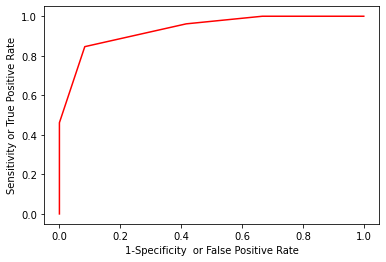

In [9]:
fpr_knn, tpr_knn, th_knn = roc_curve(cross_fold_Y_test-1, predictions_knn[:,2])
plt.plot(fpr_knn, tpr_knn, "r")
plt.xlabel("1-Specificity  or False Positive Rate")
plt.ylabel("Sensitivity or True Positive Rate")


##### Task 3.4:  Compute the AUC for the two classifier 

AUCs range between 0.5 and 1. Higher AUC indicates better classifier

In [10]:
auc_knn = roc_auc_score(cross_fold_Y_test-1, predictions_knn[:,2])
print(auc_knn)


0.9342948717948719
